In [2]:
import gpytorch
import torch
from LowPrecisionApproxGP import KERNEL_FACTORY
from LowPrecisionApproxGP.util.GreedyTrain import greedy_train
from LowPrecisionApproxGP.model.models import VarPrecisionModel
from LowPrecisionApproxGP import load_bikes, load_road3d
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

In [3]:
# # This is for baseline model, Vanilla Exact GP Model
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [34]:
# Params to tweak when running experiments

dtype = torch.float64
kwargs = {
    "training_iter": 50,
    "max_inducing_points": 50,
    "Model Name" : "JupyterNotebookModel",
    "dtype":dtype,
    "use_max" : True,
    "j" : 100,
    "max_js": 5,
}

In [35]:
# Load bikes dataset as dtype / tensor
train_data, test_data = load_bikes(dtype) # Make sure you download data first
train_x, train_y = train_data
test_x, test_y = test_data

# Create Likelihood / Model
base_kernel = KERNEL_FACTORY["base"] # Just Vanilla Base Kernel (Scale * RBF kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = VarPrecisionModel(train_x, train_y, likelihood, dtype, gpytorch.means.ConstantMean(), base_kernel())
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)

# Set to training mode
model.train()
likelihood.train()


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [36]:
print(len(train_x))

13903


In [37]:
# Train
greedy_train(
        train_data=(train_x, train_y),
        model=model,
        mll=mll,
        max_iter=kwargs.get("training_iter"),
        max_inducing_points=kwargs.get("max_inducing_points"),
        model_name=kwargs.get("Model Name"),
        dtype=kwargs.get("dtype"),
        use_max=kwargs.get("use_max"),
        j=kwargs.get("j"),
        max_js=kwargs.get("max_js"),
    )

Getting logger
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


VarPrecisionModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): VarPrecisionInducingPointKernel(
    (base_kernel): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
  )
)

In [38]:
# Eval Performance
model.eval()
likelihood.eval()

with torch.no_grad():
    trained_pred_dist = likelihood(model(test_x))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()

final_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, test_y)
final_mse = gpytorch.metrics.mean_squared_error(
    trained_pred_dist, test_y, squared=True
)

final_mae = gpytorch.metrics.mean_absolute_error(trained_pred_dist, test_y)
print(f"Mean_Standardized_Log_Test_Loss:{final_msll}")
print(f"Mean_Squared_Test_Error:{final_mse}")
print(f"Mean_Absolute_Test_Error:{final_mae}")

Mean_Standardized_Log_Test_Loss:1690.8630534094557
Mean_Squared_Test_Error:56556.41878591334
Mean_Absolute_Test_Error:163.55339135509078


In [39]:
covar_mat1 = model.covar_module._inducing_mat.numpy()

mat = np.matrix(covar_mat1)
name = "Matrices/" + str(kwargs.get("training_iter")) + "_" + str(kwargs.get("dtype")) + "_" + str(kwargs.get("use_max")) + "_" + str(kwargs.get("j")) + "_" + str(kwargs.get("max_js"))
nametxt = "Matrices/" + str(kwargs.get("training_iter")) + "_" + str(kwargs.get("dtype")) + "_" + str(kwargs.get("use_max")) + "_" + str(kwargs.get("j")) + "_" + str(kwargs.get("max_js")) + ".txt"


np.save(name, mat)
np.savetxt(nametxt, mat)

In [40]:
dtype2 = torch.float32
kwargs2 = {
    "training_iter": 50,
    "max_inducing_points": 50,
    "Model Name" : "JupyterNotebookModel",
    "dtype":dtype2,
    "use_max" : True,
    "j" : 100,
    "max_js": 5,
}

name2 = "Matrices/" + str(kwargs2.get("training_iter")) + "_" + str(kwargs2.get("dtype")) + "_" + str(kwargs2.get("use_max")) + "_" + str(kwargs2.get("j")) + "_" + str(kwargs2.get("max_js")) + ".npy"
mat2 = np.load(name2)

C:\Users\PaulQuantum\AppData\Local\Temp\ipykernel_24356\348611055.py:3: RuntimeWarning: divide by zero encountered in log
  axs[0].matshow(np.log(model.covar_module._inducing_mat.numpy()),cmap="Purples")
C:\Users\PaulQuantum\AppData\Local\Temp\ipykernel_24356\348611055.py:4: RuntimeWarning: divide by zero encountered in log
  axs[1].matshow(np.log(mat2),cmap="Purples")


NameError: name 'mpl' is not defined

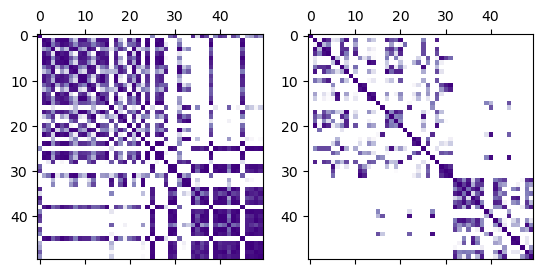

In [42]:
fig,axs = plt.subplots(1,2)

axs[0].matshow(np.log(model.covar_module._inducing_mat.numpy()),cmap="Purples")
axs[1].matshow(np.log(mat2),cmap="Purples")

axs[0].set_title("Double Precision")
axs[1].set_title("Single Precision")

fig.suptitle("Covariance Matrix Element Logarithm Scale")


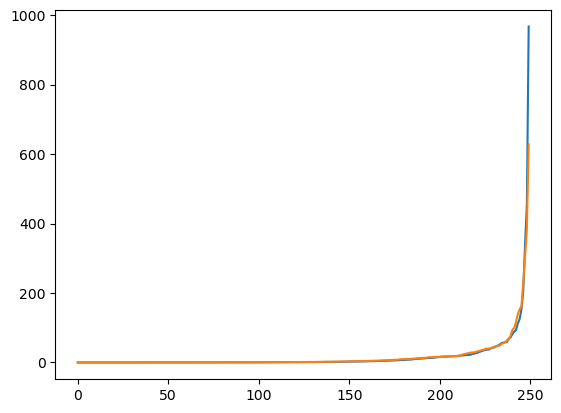

In [33]:
eigval1,eigvec1 = LA.eig(mat)
eigval2,eigvec2 = LA.eig(mat2)

eigval1 = np.sort(eigval1)
eigval2 = np.sort(eigval2)

plt.plot(eigval1)
plt.plot(eigval2)

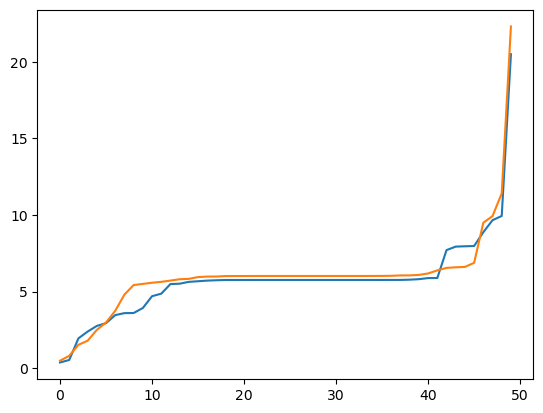